-- Epoch 1
Norm: 0.82, NNZs: 1, Bias: 0.101933, T: 349334, Avg. loss: 0.588258
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 1.06, NNZs: 1, Bias: 0.032713, T: 698668, Avg. loss: 0.588229
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 1.14, NNZs: 1, Bias: 0.035346, T: 1048002, Avg. loss: 0.588274
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 1.38, NNZs: 1, Bias: 0.089338, T: 1397336, Avg. loss: 0.588217
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 1.44, NNZs: 1, Bias: 0.069039, T: 1746670, Avg. loss: 0.588156
Total training time: 0.21 seconds.
-- Epoch 6
Norm: 1.64, NNZs: 1, Bias: 0.109117, T: 2096004, Avg. loss: 0.588201
Total training time: 0.25 seconds.
Convergence after 6 epochs took 0.25 seconds
    Number of components: 1
        Accuracy: 0.690624
        Precision: 0.693019
        Recall: 0.690574
Specificity:         74.7 

Sensitivity:         63.4 (Recall)
-- Epoch 1
Norm: 1.07, NNZs: 2, Bias: 0.090344, T: 349334, Avg. loss: 0.569888
Total training ti

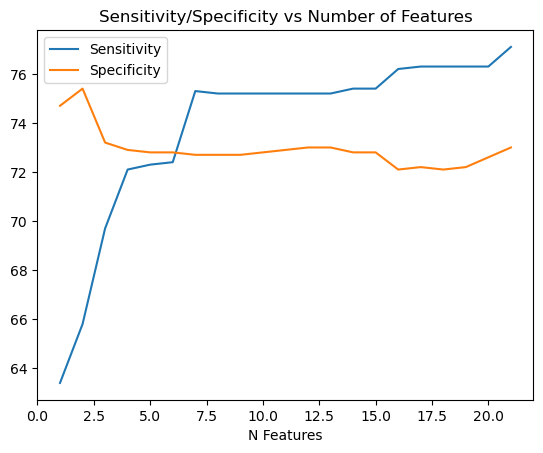

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import scipy 
from scipy import stats 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing 
import sys 
from io import StringIO
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def standardize_data(data):
    data_standardized = data.copy()
    names = data.columns
    for name in names:
        data_standardized[name] = stats.zscore(data[name])
    return data_standardized

# Fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

X = standardize_data(X)

#under-over sample
over  = SMOTE(random_state=42)
under = RandomUnderSampler(sampling_strategy='auto', random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

components_list = []
accuracy_list = []
precision_list = []
recall_list = []
sensitivity_list = []
specificity_list = []
max_components = len(X.columns)+1
components = 1
while components < max_components:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    pca = PCA(n_components=components)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
        
    logr = SGDClassifier(loss='log_loss',penalty='l1',learning_rate='constant',eta0=0.01,max_iter=1000,random_state=42,verbose=3)
    logr.fit(X_train, np.ravel(y_train,order='C'))#y_resampled_smote)
            
    y_pred = logr.predict(X_test)
    conf_m = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision =  report['macro avg']['precision'] 
    recall = report['macro avg']['recall'] 
    print("    Number of components: %d" % pca.n_components_)
    accuracy = logr.score(X_test, y_test)
    print("        Accuracy: %f" % accuracy)
    print("        Precision: %f" % precision)
    print("        Recall: %f" % recall)
    TN, FP    = conf_m[0, 0], conf_m[0, 1]
    FN, TP    = conf_m[1, 0], conf_m[1, 1]    
    TN, FP    = conf_m[0, 0], conf_m[0, 1]
    FN, TP    = conf_m[1, 0], conf_m[1, 1]
    print('Specificity:        ',  round(TN / float(TN + FP),3)*100, "\n")
    print('Sensitivity:        ',  round(TP / float(TP + FN),3)*100, "(Recall)")
    sensitivity_list.append(round(TP / float(TP + FN),3)*100)
    specificity_list.append(round(TN / float(TN + FP),3)*100)
    components_list.append(components)
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    components = components + 1
plt.figure()
plt.plot(components_list, sensitivity_list, label='Sensitivity')
plt.plot(components_list, specificity_list, label='Specificity')
plt.xlabel("N Features")
plt.legend()
plt.title('Sensitivity/Specificity vs Number of Features')
plt.rcParams["figure.figsize"] = (5,3)    
# Clear lists
components_list = []
accuracy_list = []
recall_list = []
precision_list = []